In [9]:
## APPLY MULTIPLE REGRESSION METHODS TO THE TITANIC DATASET ##

# Logistic Regression
# Random Forest Classifier
# Support Vector Machines
# Neural Networks (Tensor Flow)

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

C:\Users\hp1\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib inline

In [4]:
#Function to create the training dataframe from the input data

def create_model_data(filename):
    titanic=pd.read_csv(filename,header=0,index_col=False)
    
    #Using the Age, Passenger Class and Sex to determine the average age for all conditional categories.
    #Use the data to fill up the gaps in the dataframe
    fem_avg_age_1=titanic['Age'][(titanic['Sex']=='female') & (titanic['Pclass']==1)].mean()
    fem_avg_age_2=titanic['Age'][(titanic['Sex']=='female') & (titanic['Pclass']==2)].mean()
    fem_avg_age_3=titanic['Age'][(titanic['Sex']=='female') & (titanic['Pclass']==3)].mean()
    male_avg_age_3=titanic['Age'][(titanic['Sex']=='male') & (titanic['Pclass']==3)].mean()
    male_avg_age_2=titanic['Age'][(titanic['Sex']=='male') & (titanic['Pclass']==2)].mean()
    male_avg_age_1=titanic['Age'][(titanic['Sex']=='male') & (titanic['Pclass']==1)].mean()
    for index in list(titanic.index):
        if titanic.loc[index,'Sex']=='female' and titanic['Age'].isnull()[index]==True:
            if titanic.loc[index,'Pclass']==1:
                titanic.loc[index,'Age']=fem_avg_age_1
            if titanic.loc[index,'Pclass']==2:
                titanic.loc[index,'Age']=fem_avg_age_2
            if titanic.loc[index,'Pclass']==3:
                titanic.loc[index,'Age']=fem_avg_age_3
        elif titanic.loc[index,'Sex']=='male' and titanic['Age'].isnull()[index]==True:
            if titanic.loc[index,'Pclass']==3:
                titanic.loc[index,'Age']=male_avg_age_3
            if titanic.loc[index,'Pclass']==2:
                titanic.loc[index,'Age']=male_avg_age_2
            if titanic.loc[index,'Pclass']==1:
                titanic.loc[index,'Age']=male_avg_age_1

    #Create a column with 1 value if Passenger's cabin is known and 0 is unknown
    cabin_known=[]
    for index in list(titanic.index):
        if titanic['Cabin'].isnull()[index]==True:
            cabin_known.append(0)
        else:
            cabin_known.append(1)
    titanic['cabin_known']=cabin_known
    titanic.drop('Cabin',axis=1,inplace=True)
    
    #Split the embarked column into the specific columns for the 3 locations from where the passengers boarded the Titanic
    titanic.fillna('S',axis=0,inplace=True)
    new_embarked=[]
    port_map={'C':0,'Q':1,'S':2}
    for index in list(titanic.index):
        new_embarked.append(port_map[titanic.loc[index,'Embarked']])
    titanic['Embarked']=new_embarked

    #Split the Sex column into the specific columns for Males and Females
    titanic=titanic.join(pd.get_dummies(titanic['Sex'],drop_first=True))

    #Use the SiblingSpoouse and ParentsChildren columns to find the people with any immediate family on-board and those alone.
    fam_on_board=[]
    alone=[]
    for index in list(titanic.index):
        fam_on_board.append(titanic.loc[index,'SibSp']+titanic.loc[index,'Parch'])
        if (titanic.loc[index,'SibSp']+titanic.loc[index,'Parch'])!=0:
            alone.append(0)
        else:
            alone.append(1)
    titanic['Fam_on_board']=fam_on_board
    titanic['Alone']=alone

    #Calculate the average cost per ticket for every individual to get a better idea of their wealth.
    cost_per_ticketholder=[]
    for index in list(titanic.index):
        if titanic.loc[index,'Fam_on_board']==0:
            cost_per_ticketholder.append(titanic.loc[index,'Fare'])
        else:
            cost_per_ticketholder.append(titanic.loc[index,'Fare']/titanic.loc[index,'Fam_on_board'])
    titanic['Cost_per_ticketholder']=cost_per_ticketholder
    
    #Get a separate column for each title in an individual's name to check for any correlation with their wealth and their chances of survival.
    title=[]
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4}
    for name in titanic['Name'].tolist():
        short=name.split(',')[1].split('.')[0].replace(" ",'')
        try:
            title.append(title_mapping[short])
        except:
            title.append(5)
    titanic['Title']=title

    #Drop the extra columns
    titanic.drop(['Name','Sex','Ticket'],axis=1,inplace=True)
    
    #Return the DataFrames 
    try:
        return titanic[['Survived','Pclass','Age','Parch','Embarked','cabin_known','male','Fam_on_board','Alone','Cost_per_ticketholder','Title']]
    except:
        return titanic[['PassengerId','Pclass','Age','Parch','Embarked','cabin_known','male','Fam_on_board','Alone','Cost_per_ticketholder','Title']]

In [7]:
#Create Training and Testing Data

train_data=create_model_data('train.csv')
test_data=create_model_data('test.csv')
passenger_ID=test_data['PassengerId'].tolist()
test_data.drop('PassengerId',axis=1,inplace=True)
print(test_data.columns)

Index(['Pclass', 'Age', 'Parch', 'Embarked', 'cabin_known', 'male',
       'Fam_on_board', 'Alone', 'Cost_per_ticketholder', 'Title'],
      dtype='object')


In [4]:
titanic=pd.read_csv('train.csv',header=0,index_col=False)

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

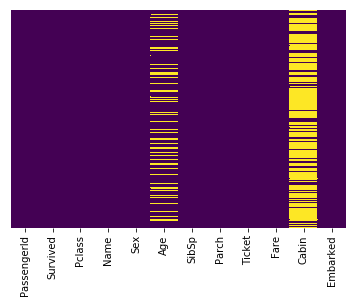

In [8]:
#Find the null values in the DataFrame which have to be removed

sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

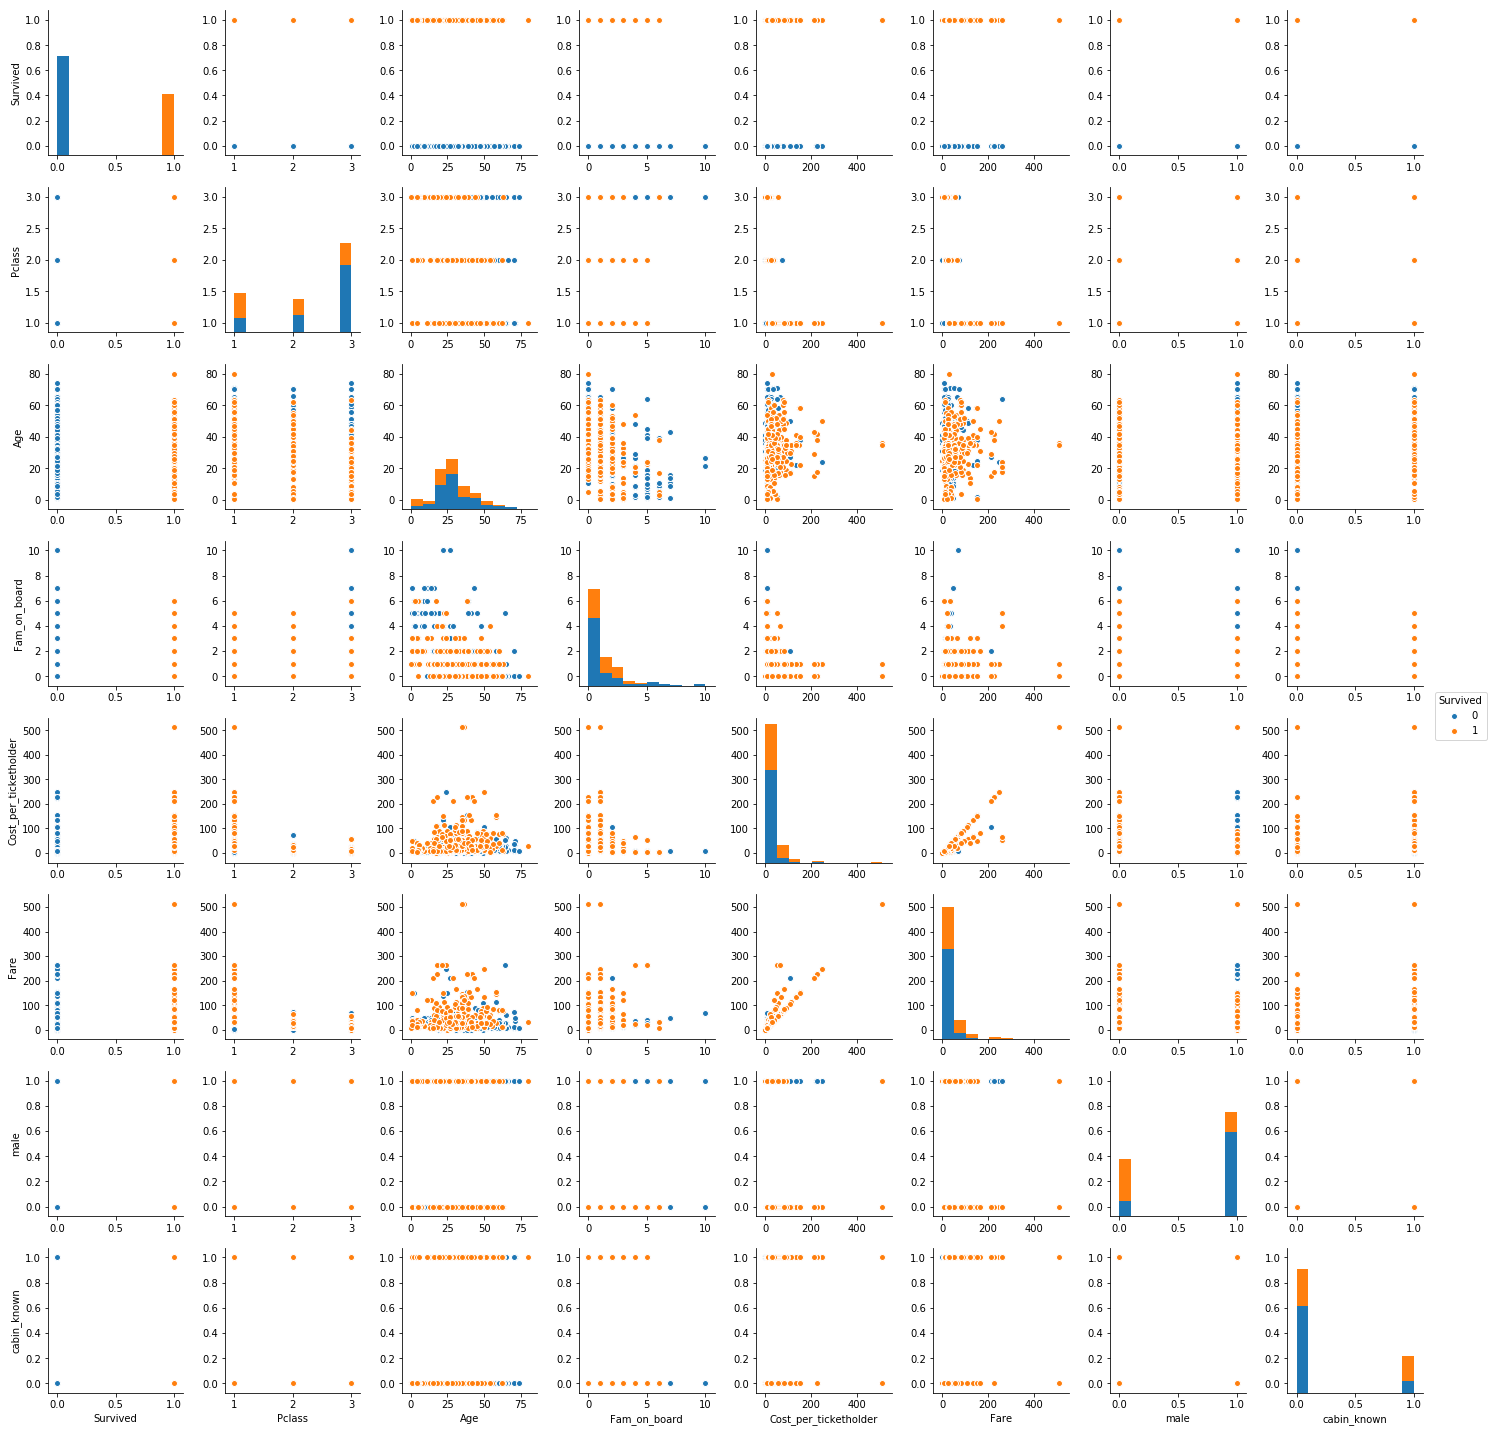

In [156]:
#Gives the pairplots to analyse the distribution of the variables wrt each other.

sns.pairplot(titanic[['Survived', 'Pclass','Age', 'Fam_on_board', 'Cost_per_ticketholder','Fare','male','cabin_known']],hue='Survived')

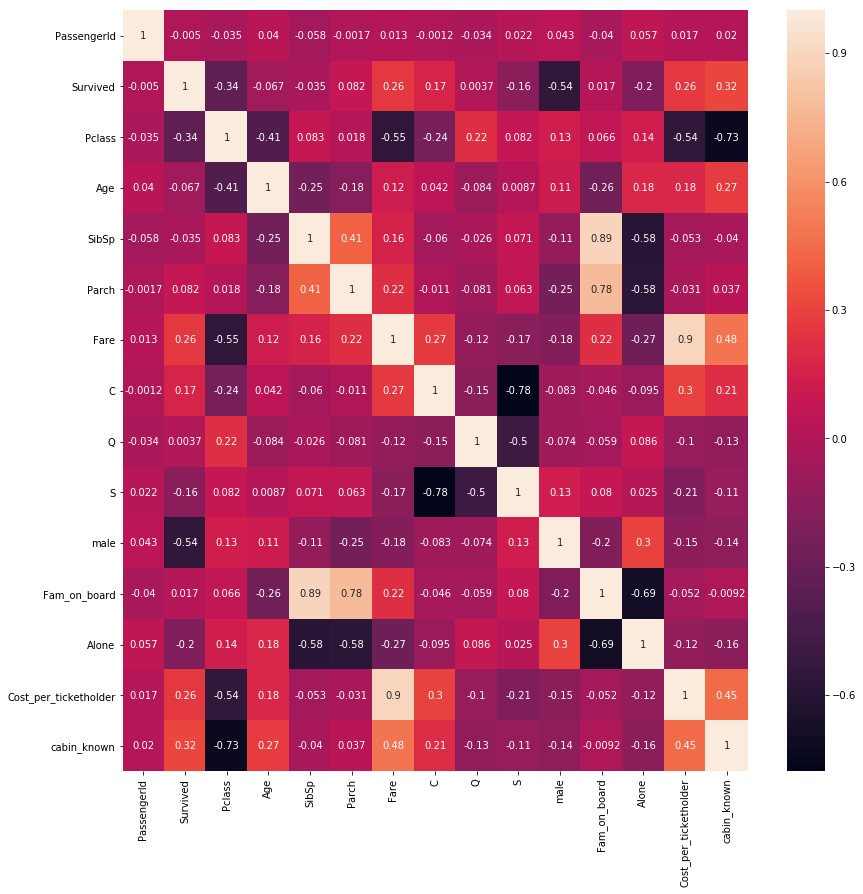

In [198]:
#Heatmap to know correlation between the variables

fig,ax=plt.subplots(figsize=(14,14))
sns.heatmap(titanic.corr(),annot=True)

In [ ]:
titanic=create_model_data('train.csv')

In [179]:
## LOGISTIC REGRESSION ##

train_df=titanic[['Survived','Pclass','Age','Alone', 'C','S', 'male']]

X=train_df.drop(['Survived'],axis=1)
y=train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

from sklearn.linear_model import LogisticRegression
logmodel=LogisticRegression()
logmodel.fit(X_train,y_train)
predictions_log=logmodel.predict(X_test)

print(classification_report(y_test,predictions_log))
print('\n')
print(confusion_matrix(y_test,predictions_log))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        99
           1       0.85      0.71      0.78        80

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.81       179



[[89 10]
 [23 57]]


C:\Users\hp1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [160]:
## RANDOM FOREST CLASSIFIER ##

train_df=titanic[['Survived','Pclass','Age','Alone', 'C','S', 'male']]

X=train_df.drop(['Survived'],axis=1)
y=train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=101)

from sklearn.ensemble import RandomForestClassifier as RFC
RFC=RFC(n_estimators=10)
RFC.fit(X_train,y_train)
predictions_RFC=RFC.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test,predictions_log))
print('\n')
print(confusion_matrix(y_test,predictions_log))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       110
           1       0.83      0.69      0.75        87

    accuracy                           0.80       197
   macro avg       0.81      0.79      0.79       197
weighted avg       0.81      0.80      0.80       197



[[98 12]
 [27 60]]


In [161]:
## SUPPORT VECTOR MACHINE ##

train_df=titanic[['Survived','Pclass','Age','Alone', 'C','S', 'male']]

X=train_df.drop(['Survived'],axis=1)
y=train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=101)

from sklearn.svm import SVC
SVM=SVC()
SVM.fit(X_train,y_train)
predictions_SVM=SVM.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test,predictions_log))
print('\n')
print(confusion_matrix(y_test,predictions_log))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       110
           1       0.83      0.69      0.75        87

    accuracy                           0.80       197
   macro avg       0.81      0.79      0.79       197
weighted avg       0.81      0.80      0.80       197



[[98 12]
 [27 60]]


C:\Users\hp1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [163]:
## RANDOM FOREST CLASSIFIER ##

train_df=titanic[['Survived','Pclass','Age','Alone', 'C','S', 'male']]

X=train_df.drop(['Survived'],axis=1)
y=train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

from sklearn.ensemble import RandomForestClassifier as RFC
RFC=RFC(n_estimators=10)
RFC.fit(X_train,y_train)
predictions_RFC=RFC.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test,predictions_log))
print('\n')
print(confusion_matrix(y_test,predictions_log))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        99
           1       0.85      0.71      0.78        80

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.81       179



[[89 10]
 [23 57]]


In [164]:
## SUPPORT VECTOR MACHINE ##

train_df=titanic[['Survived','Pclass','Age','Alone', 'C','S', 'male']]

X=train_df.drop(['Survived'],axis=1)
y=train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

from sklearn.svm import SVC
SVM=SVC()
SVM.fit(X_train,y_train)
predictions_SVM=SVM.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test,predictions_log))
print('\n')
print(confusion_matrix(y_test,predictions_log))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        99
           1       0.85      0.71      0.78        80

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.81       179



[[89 10]
 [23 57]]


C:\Users\hp1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [180]:
                        ### NEURAL NETWORK ###

        #with extra hidden layer of 10,20,10 and batch size 10

X_in=titanic[['Pclass','Age','SibSp','Parch', 'C','S', 'male']]
y_in=titanic['Survived']

scaler=StandardScaler()
scaler.fit(X_in)
scaled_X=scaler.transform(X_in)
data_input=pd.DataFrame(data=scaled_X, columns=list(X_in.columns))

X_train, X_test, y_train, y_test = train_test_split(data_input, y_in, test_size=0.20, random_state=101)

feat_col=[]
for head in data_input.columns:
    feat_col.append(tf.feature_column.numeric_column(head))
feat_col

classifier=tf.estimator.DNNClassifier(hidden_units=[10,20,10],n_classes=20,feature_columns=feat_col)

in_func=tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train, batch_size=10,shuffle=True)

classifier.train(input_fn=in_func,steps=500)

pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=50,shuffle=False)

predictions = list(classifier.predict(input_fn=pred_fn))

final_preds=[]
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

print('\n')
print(confusion_matrix(y_test,final_preds))
print('\n')
print(classification_report(y_test,final_preds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmpht3mg2y5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000008AFF3CAB38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into 

In [183]:
                        ### NEURAL NETWORK ###

                        # THE BEST MODEL YET #
        #with extra hidden layer of 10,10,10 and batch size 10

X_in=titanic[['Pclass','Age','SibSp','Parch', 'C','S', 'male']]
y_in=titanic['Survived']

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_in)
scaled_X=scaler.transform(X_in)
data_input=pd.DataFrame(data=scaled_X, columns=list(X_in.columns))

X_train, X_test, y_train, y_test = train_test_split(data_input, y_in, test_size=0.20, random_state=101)

feat_col=[]
for head in data_input.columns:
    feat_col.append(tf.feature_column.numeric_column(head))
feat_col

classifier=tf.estimator.DNNClassifier(hidden_units=[10,10,10],n_classes=20,feature_columns=feat_col)

in_func=tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train, batch_size=10,shuffle=True)

classifier.train(input_fn=in_func,steps=500)

pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=50,shuffle=False)

predictions = list(classifier.predict(input_fn=pred_fn))

final_preds=[]
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

print('\n')
print(confusion_matrix(y_test,final_preds))
print('\n')
print(classification_report(y_test,final_preds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmp8nbvcdf4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000008A85DDAF28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into 

In [197]:
## LOGISTIC REGRESSION ##

train_df=titanic[['Survived','Pclass','Age','SibSp','Parch', 'C','S', 'male']]

X=train_df.drop(['Survived'],axis=1)
y=train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

from sklearn.linear_model import LogisticRegression
logmodel=LogisticRegression()
logmodel.fit(X_train,y_train)
predictions_log=logmodel.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test,predictions_log))
print('\n')
print(confusion_matrix(y_test,predictions_log))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       127
           1       0.81      0.65      0.72        96

    accuracy                           0.78       223
   macro avg       0.79      0.76      0.77       223
weighted avg       0.78      0.78      0.78       223



[[112  15]
 [ 34  62]]


C:\Users\hp1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
